In [145]:
## IMPORTAMOS LAS LIBRERIAS PARA EL MANEJO DEL SISTEMA SLIT, REDES NEURONALES Y SISTEMAS MATEMATICOS
#sys.path.append('D:/projects/base/app/modules') 
## RAZONAMIENTO MATEMATICO######################
import numpy as np
from scipy.signal import lti 
from scipy import stats
from scipy.stats import expon
import scipy.fftpack as fourier
from scipy.fftpack import fft, fftfreq, fftshift
import seaborn as sns ## LIBRERIA PARA HISTOGRAMA 
from numpy import logspace
import sympy as sym
import pandas as pd
######################
# ############################


##### GRAFICACIÓN#######################
import matplotlib.pyplot as plt
########################################


##MANEJO DEL CIRCUITO###########################
from lcapy import Circuit, j, omega, s
################################################


####################REDES_NEURONALES#####################
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf
from keras import layers,models,optimizers
from keras import regularizers
########################################################


##################LIBRERIAS PROPIAS########################
from  Librerias_Señales.Libreria_fourier import * 
###########################################################


In [146]:
########### CONTRUIMOS EL CIRCUITO##########################:

ctt=Circuit("""
Vi 1 0_1 step;down
C1 1 2; right, size=1.5
R1 2 0; down, size=1.5
C2 2 3; right
R3 2 3; right, offset=0.7
R2 3 0_3; down , v=(V_o)
W 0_1 0;right
W 0 0_3;right
"""
)

"""
Descripción arquitectura anterior:
- Vi va del nodo 1 al nodo 0_! y va hacia abajo.
- C1 va del nodo 1 al nodo 2 y va hacia la derecha.
- R1 va del nodo 2 al nodo 0 y va hacia abajo.
- C2 va del nodo 2 al nodo 3 hacia la derecha.
- R3 va del nodo 2 al nodo 3 hacia la derecha (En paralelo a C2 con una distancia de 0.9)
- R2 ba del nodo 3 al nodo 0_3 hacia abajo. 
- Se tira un cable del nodo 0_1 al nodo 1.
- Se tira un cable del nodo 0 al nodo 0_3.
 (size=1.5 es el calibre del cable).
"""


'\nDescripción arquitectura anterior:\n- Vi va del nodo 1 al nodo 0_! y va hacia abajo.\n- C1 va del nodo 1 al nodo 2 y va hacia la derecha.\n- R1 va del nodo 2 al nodo 0 y va hacia abajo.\n- C2 va del nodo 2 al nodo 3 hacia la derecha.\n- R3 va del nodo 2 al nodo 3 hacia la derecha (En paralelo a C2 con una distancia de 0.9)\n- R2 ba del nodo 3 al nodo 0_3 hacia abajo. \n- Se tira un cable del nodo 0_1 al nodo 1.\n- Se tira un cable del nodo 0 al nodo 0_3.\n (size=1.5 es el calibre del cable).\n'

In [100]:
#ctt.draw() # Resolver

c:\Users\DeLL-PC\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The to_png function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
c:\Users\DeLL-PC\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The to_rgba function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
c:\Users\DeLL-PC\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The to_mask function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
c:\Users\DeLL-PC\AppData\L

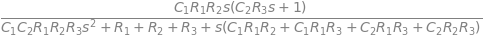

In [147]:
### OBSERVAMOS LAS CARACTERISTICAS DE NUESTRO CIRCUITO (FUNCIÓN DE TRANSFERENCIA Y RESPUESTA AL IMPULSO)

##GENERAMOS LA FUNCIÓN DE TRANSFERENCIA DEL CIRCUITO TOMANDO LA SALIDA EN R2
H=(ctt.R2.V(s)/ctt.Vi.V(s)).simplify()
H

In [148]:
#Dando valores al circuito:
C1=4.7e-4
C2=4.7e-4
R1=1000
R2=2000
R3=500
Coeficientes_num=[C1*C2*R1*R2*R3, C1*R1*R2] #Coeficientes numerador
Coeficientes_dem=[C1*C2*R1*R2*R3, C1*R1*R2 + C1*R1*R3 + C2*R1*R3 + C2*R2*R3, R1 + R2 + R3] #Coeficientes denominador

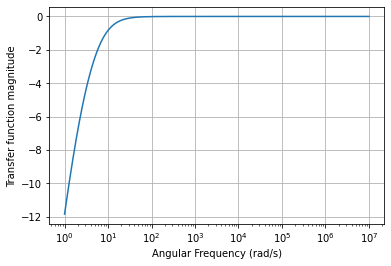

In [149]:
### LE ASIGNAMOS LOS VALORES A NUESTRA FUNCIÓN DE TRANSFERENCIA PARA VER EL COMPORTAMIENTO DEL CIRCUITO
### ASOCIADO A LOS PARAMETROS:
H_valores=H.subs("C1",C1).subs("C2",C2).subs("R1",R1).subs("R2",R2).subs("R3",R3)
W=logspace(0,7,2000) ## GENERAMOS VECTOR DE FRECUENCIAS EN ESCALA LOGARITMICA
X=H_valores(j*omega).dB.plot(W,log_frequency=True) ## GRAFICAMOS SEGUN UN VECTOR DE FRECUENCIAS

## FILTRO PASA ALTAS (IMPORTANTE)

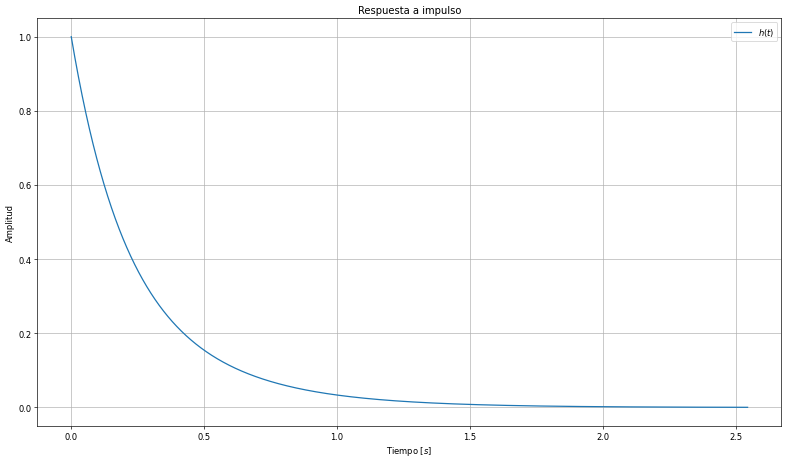

In [150]:
## AHORA ANALIZANDO LA RESPUESTA AL IMPULSO DEL SISTEMA, Y ASIGNANDO LOS VALORES AL MODELADO DEL CIRCUITO:
##OBSERVAMOS LA RESPUESTA AL IMPULSO:

lti_system = lti(Coeficientes_num, Coeficientes_dem)   #LTI
Nsample=4096 ## CANTIDAD DE MUESTRAS
t, h = lti_system.impulse(N=Nsample) # sistema LTI exitado con la función impulso
## NOS DEVUELVE 

plt.figure(figsize=(16, 9), dpi=60)
plt.plot(t, h, label='$h(t)$')

plt.grid(True)
plt.legend()
plt.title("Respuesta a impulso")
plt.xlabel("Tiempo [$s$]")
plt.ylabel("Amplitud")
plt.show()

No handles with labels found to put in legend.


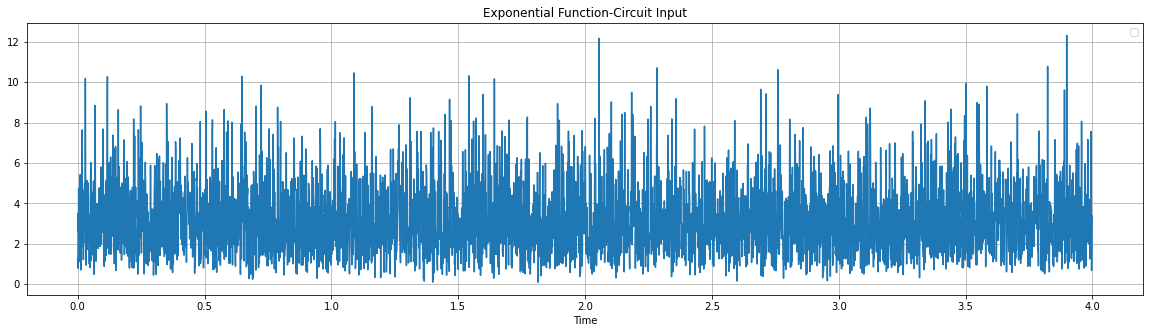

<Figure size 1440x360 with 0 Axes>

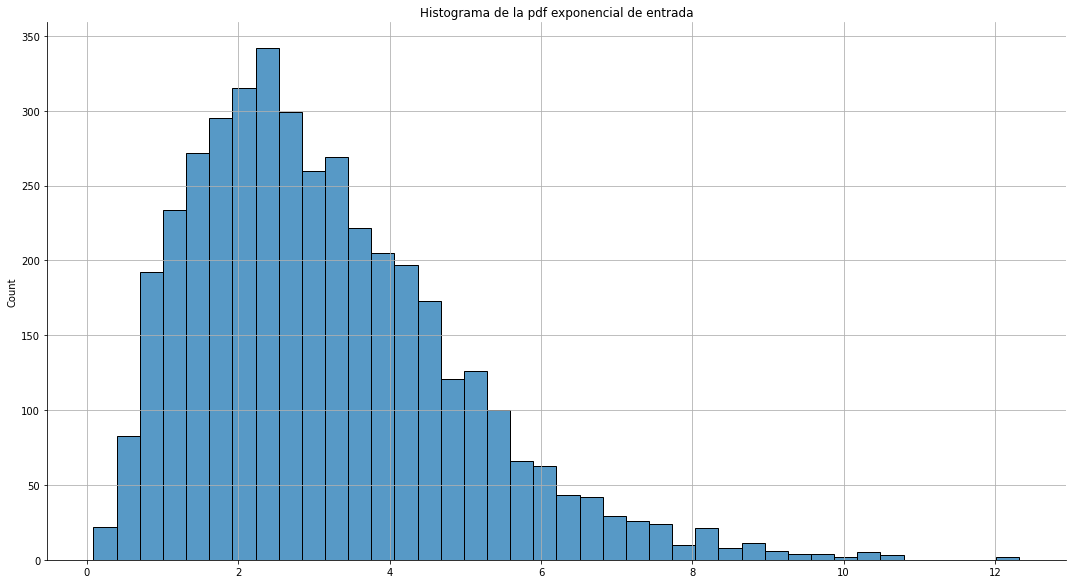

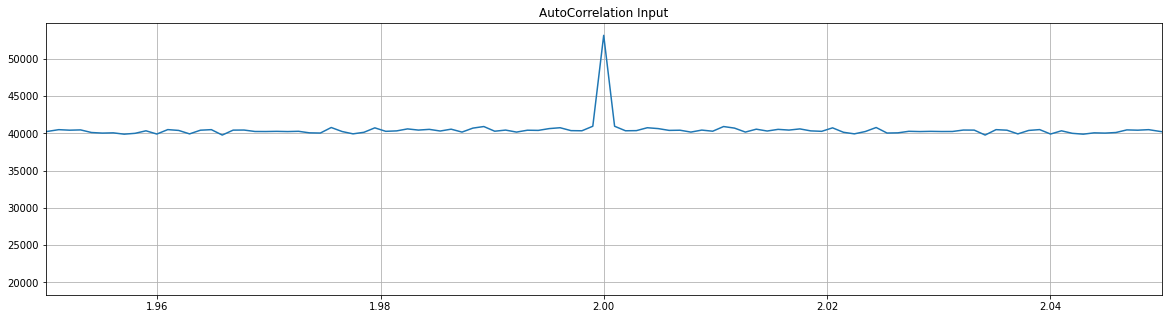

In [151]:
## GENERAMOS LA ENTRADA DE NUESTRO CIRCUITO:

Nbins=int((1+3.322*np.log2(Nsample)))### NUMERO DE BINS PARA EL HISTOGRAMA
Fdisc=Nsample/4 # FRECUENCIA DE MUESTREO
Tdisc=1/Fdisc
t=np.arange(0,4,Tdisc) ## GENERAMOS VECTOR DE TIEMPO PARA NUESTRA FUNCIÓN ALEATORIA

shape= np.pi     
gamma= np.random.gamma(shape,size=len(t))
Autocorrelacion_expt=np.correlate(gamma,gamma,mode="same") ## GENERAMOS LA AUTOCORRELACION

plt.figure(figsize=(20,5))
plt.plot(t,gamma)
plt.title("Exponential Function-Circuit Input")
plt.xlabel("Time")
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(20,5))
sns.displot(gamma,bins=Nbins,height=8, aspect=15/8)
#sns.set(rc = {'figure.figsize':(20,5)})
hist_kws={"edgecolor":"balck"}
plt.title("Histograma de la pdf exponencial de entrada")
plt.grid()
plt.show()

plt.figure(figsize=(20,5))
plt.plot(t,Autocorrelacion_expt)
plt.xlim(1.95,2.05)
hist_kws={"edgecolor":"balck"}
plt.title("AutoCorrelation Input")
plt.grid()
plt.show()






c:\Users\DeLL-PC\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The to_png function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
c:\Users\DeLL-PC\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The to_rgba function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
c:\Users\DeLL-PC\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The to_mask function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
c:\Users\DeLL-PC\AppData\L

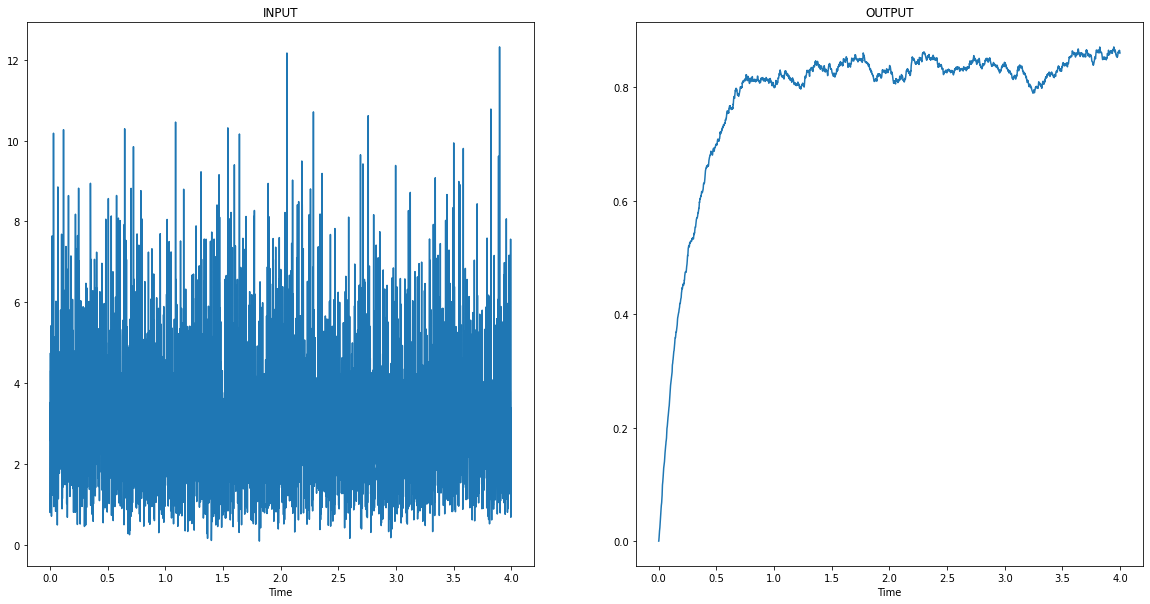

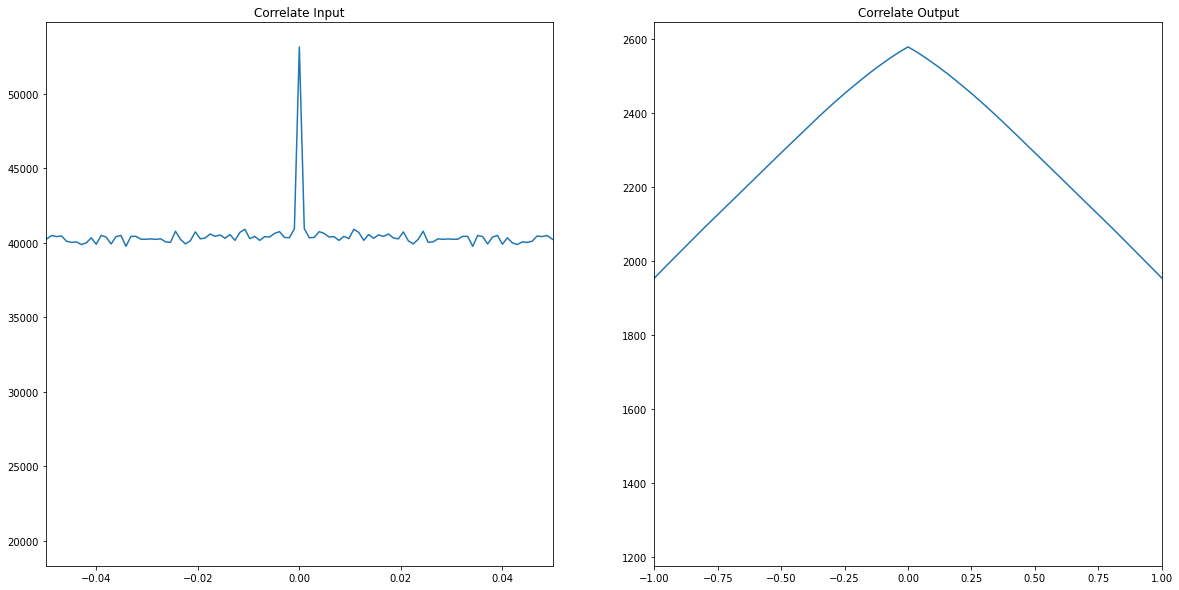

In [155]:
## INGRESAMOS LA ENTRADA EXPONENCIAL A NUESTRO CIRCUITO:
_,Output_Circuit,_=lti_system.output(gamma, t) ##SALIDA DEL CIRCUITO.
Autocorrelacion_Output=np.correlate(Output_Circuit,Output_Circuit,mode="same") ## GENERAMOS LA AUTOCORRELACION
# COMPARAMOS ENTRADA VS SALIDA 
fig, axs = plt.subplots(1, 2,figsize=(20,10))
axs[0].plot(t, gamma)
axs[0].set_title("INPUT")
axs[0].set_xlabel("Time")
axs[1].plot(t, Output_Circuit)
axs[1].set_title("OUTPUT")
axs[1].set_xlabel("Time")




fig, axs = plt.subplots(1, 2,figsize=(20,10))
axs[0].plot(t-2,Autocorrelacion_expt)
axs[0].set_title("Correlate Input")
axs[0].set_xlim(-0.05,0.05)
axs[1].plot(t-2, Autocorrelacion_Output)
axs[1].set_title("Correlate Output")
axs[1].set_xlim(-1,1)


### CALCULAMOS LA DENSIDAD ESPECTRAL DE POTENCIA PARA ENTRADA Y SALIDA
### A PRIORI DEBERIAMOS OBTENER UN MAYOR ANCHO DE BANDA EN LA ENTRADA A COMPARACIÓN DE LA SALIDA

#Fourier



      TIPO DE PLOTEO NO ADMITIDO
      TIPO DE PLOTEO NO ADMITIDO


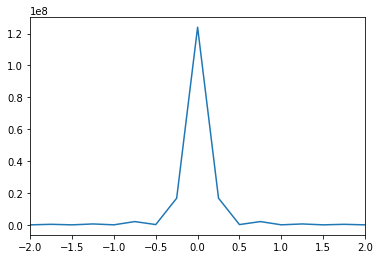

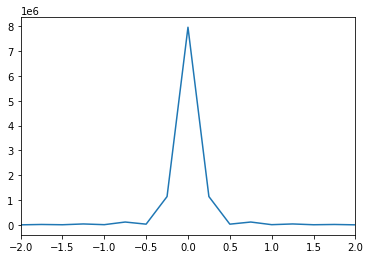

In [156]:
Ft,W=Fourier_Transform(Autocorrelacion_expt,t,xlim=[-2,2],Plot="None",Title="Input")
Ft_op,W_op=Fourier_Transform(Autocorrelacion_Output,t,xlim=[-2,2],Plot="None",Title="Output")

plt.plot(W,np.sqrt((Ft.real**2)+(Ft.imag**2)))
plt.xlim(-2,2)
plt.show()

plt.plot(W_op,np.sqrt((Ft_op.real**2)+(Ft_op.imag**2)))
plt.xlim(-2,2)
plt.show()


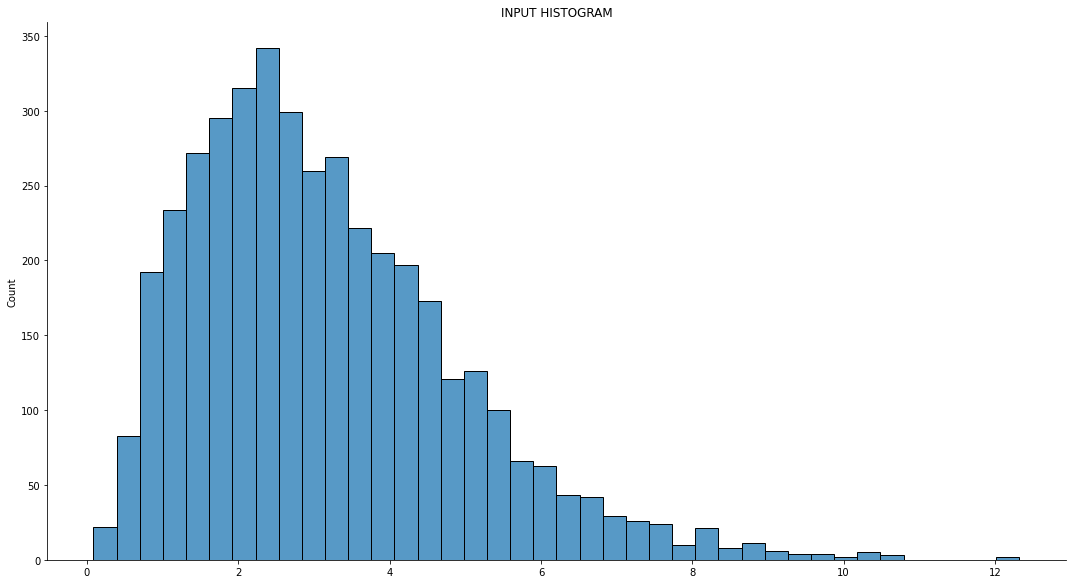

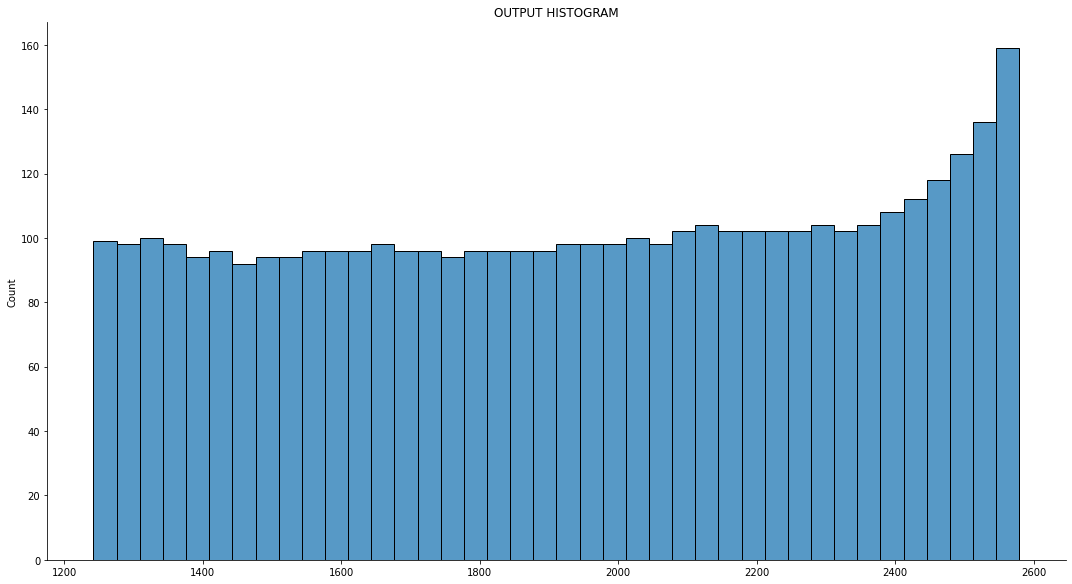

In [157]:
### COMPARANDO HISTOGRAMAS:


sns.displot(gamma,bins=Nbins,height=8, aspect=15/8).set(title='INPUT HISTOGRAM')
sns.displot(Autocorrelacion_Output,bins=Nbins,height=8, aspect=15/8).set(title='OUTPUT HISTOGRAM')
plt.show()

In [307]:
### DEFINIMOS LOS SETS DE ENTRENO Y TESTEO
## 4 SETS DE VALIDACIONES
## DEFINIMOS LOS SET DE ENTRENO TESTEO y VALIDACIÓN

## NOS CENTRAMOS EN EL TRANSITORIO#####
Y_train=Output_Circuit[:1000].astype("float32")
X_train=gamma[:1000].astype("float32")
#######################################

###################################
Y_VAL=Output_Circuit[1000:2200].astype("float32")
X_val=gamma[1000:2200].astype("float32")
###################################

Y_test=Output_Circuit[2200:].astype("float32")
X_test=gamma[2200:].astype("float32")



In [289]:
Y_VAL.shape

In [290]:

## NOS CENTRAMOS EN EL TRANSITORIO#####
#Y_train=Y_train[:,np.newaxis]
#X_train=X_train[:,np.newaxis]
#######################################

###################################
#Y_VAL=Y_VAL[:,np.newaxis]
#X_val=X_val[:,np.newaxis]
###################################

#Y_test=Y_test[:,np.newaxis]
#X_test=X_test[:,np.newaxis]



In [291]:
Y_VAL.shape

In [327]:
## GENERAMOS NUESTRA RED NEURONAL VAMOS A UTILIZAR UNA SIMPLE DE LA SIGUIENTE FORMA
### DEFINIMOS LA CANTIDAD DE NEURONAS POR CAPA
 
Nodos1 = 3
Nodos2 = 3
lr=0.01
model=models.Sequential()
model.add(layers.Dense(Nodos1,activation="relu",input_shape=(1),kernel_regularizer=regularizers.l1(0.01))) ## 10000 LAS PALABRAS QUE TIENE PARA LA CLASIFICACIÓN
model.add(layers.Dense(Nodos2,activation="relu",kernel_regularizer=regularizers.l1(0.01)))
model.add(layers.Dense(1)) ## COMO ES LINEAL LA SALIDA NO NECESITO PONERLE UNA CAPA DE ACTIVACIÓN
model.compile(optimizer=optimizers.RMSprop(lr=lr),loss="mse",metrics=['accuracy']) # Loss Function 


TypeError: 'int' object is not iterable

In [324]:
## ENTRENAMOS EL MODELO
history=model.fit(gamma,Output_Circuit,epochs=30,batch_size=10,validation_data=(X_val,Y_VAL),verbose=0)

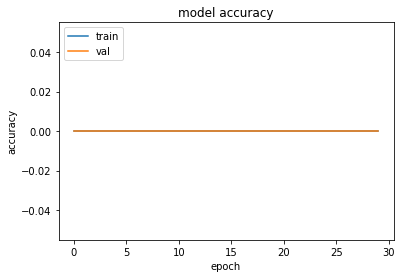

In [326]:

## GENERAMOS NUESTRO MUESTREO DE OVERFITTING:

history_dict=history.history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [281]:
model.evaluate(X_train,Y_train)


32/32 [==============================] - 1s 2ms/step - loss: 2.7972 - accuracy: 0.0000e+00


c:\Users\DeLL-PC\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The to_png function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
c:\Users\DeLL-PC\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The to_rgba function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
c:\Users\DeLL-PC\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The to_mask function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
c:\Users\DeLL-PC\AppData\L

32/32 [==============================] - 0s 3ms/step


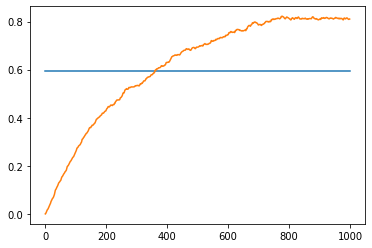

In [205]:
Y_predict=model.predict(X_train)
plt.plot(Y_predict)
plt.plot(Y_train)